# Numerically solving the 2D heat equation using the method of lines
In this notebook I'm going to experiment with some techniques from the course *Numerical Methods for Time Dependent PDEs* to solve the 2D heat equation on the unit square $\Omega = [0,1] \times [0,1]$ between $T=[0,1]$
\begin{align*}
&u_t = \kappa\Delta u \qquad\qquad\quad \text{in } \Omega \times T\\
& u = 0 \qquad\qquad\qquad \: \: \text{on } \partial \Omega \times T\\
& u_0 = \exp(-x^2 - 4y^2) \quad \text{in } \Omega
\end{align*}
We will choose the standard uniform $4$ point stencil to approximate the Laplacian on the interior nodes, this yields us the system of ordinary differential equations
\begin{equation}
\dfrac{\mathrm{d}}{\mathrm{d}t} u(t) = \dfrac{u_{i+1,j}(t) + u_{i-1, j}(t) + u_{i, j+1}(t) + u_{i, j-1}(t) - 4u_{i,j}(t)}{h^2}
\end{equation}
The next step will be to choose a suitable time integration method, I will look at
1) Forward Euler

2) Trapezoidal rule

3) Alternating direction (ADI)

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.animation as animation

## Some useful functions

In [3]:
# Function returns the initial temperature corresponding to the size of the grid
def construct_IC(x_size, y_size, init_func):
    x_dir, y_dir = np.mgrid[0:1:x_size * 1j, 0:1:x_size * 1j]
    return init_func(x_dir, y_dir), x_dir, y_dir


def update_plot(t_idx, temperature, plot, x_vals, y_vals):
    plot[0].remove()
    plot[0] = ax.plot_surface(x_vals, y_vals, temperature[t_idx,:,:], cmap="magma")

# Function to plot/animate the resulting temperature distribution over time
def animate_temperature_distribution(temperature, x_vals, y_vals):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plot = [ax.plot_surface(x_vals, y_vals, temperature[0,:,:], color='0.75', rstride=1, cstride=1, cmap="magma")]
    ax.set_zlim(0, 1.5)
    nmax, _, _ = temperature.shape
    animate = animation.FuncAnimation(fig, update_plot, nmax, fargs=(temperature, plot, x_vals, y_vals))
    plt.show()
        

## Forward Euler

We are going to apply the basic Forward Euler method to discretize the time direction, this yields the following system to be solved at time $t^n = n \Delta t$:
$$\dfrac{u_{i,j}^{n+1} - u_{i,j}^n}{\Delta t} = \kappa\dfrac{u_{i+1,j}^n + u_{i-1, j}^n + u_{i, j+1}^n + u_{i, j-1}^n - 4u_{i,j}^n}{h^2}$$
We can write this as an explicit update, which yields:
$$u_{i,j}^{n+1}= u_{i,j}^n + \dfrac{\kappa \Delta t}{h^2}(u_{i+1,j}^n + u_{i-1, j}^n + u_{i, j+1}^n + u_{i, j-1}^n - 4u_{i,j}^n)$$


In [4]:
# Function which returns the solution of the 2D heat equation as the 3D array (t, x, y)
# We solve the heat equation using the Forward in Time, Center in Space method (FTCS)
def heat_FTCS_2D(t_size, end_time, kappa, init_temp, bc=0):
    # Get the size of the uniform grid
    x_size, y_size = init_temp.shape
    dt = end_time / t_size
    temperature = np.zeros((t_size, x_size, y_size))
    # Set initial condition
    temperature[0, :, :] = init_temp
    
    # Set boundary condition
    for t_idx in range(0, t_size):
        temperature[t_idx, 0, :] = bc  # Bottom
        temperature[t_idx, -1, :] = bc # Top 
        temperature[t_idx, :, 0] = 3  # Left
        temperature[t_idx, -1, 0] = bc # Right
        
    # Calculate heat values
    rho = kappa * dt * x_size ** 2
    for t_idx in range(0, t_size - 1):
        for x_idx in range(1, x_size - 1):
            for y_idx in range(1, y_size - 1):
                temperature[t_idx + 1, x_idx, y_idx] = (temperature[t_idx, x_idx, y_idx] + 
                                                    rho * (
                                                               temperature[t_idx, x_idx + 1, y_idx] +
                                                               temperature[t_idx, x_idx - 1, y_idx] +
                                                               temperature[t_idx, x_idx, y_idx + 1] +
                                                               temperature[t_idx, x_idx, y_idx - 1] -
                                                           4 * temperature[t_idx, x_idx, y_idx]
                                                          ))
    return temperature
    

<IPython.core.display.Javascript object>


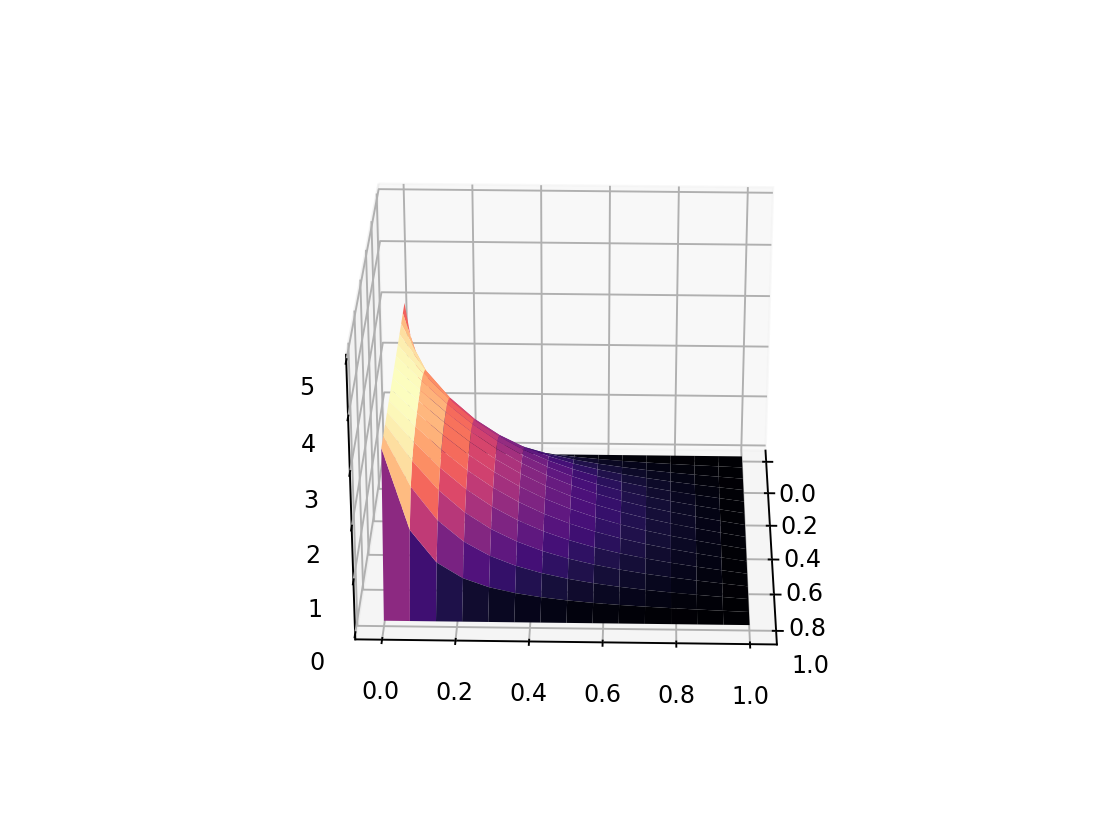

In [5]:
# Problem specific variables
kappa = 0.25
t_size = 400
end_time = 1
xy_size = 15

# Initial data and mesh
init_func = lambda x, y : 5*np.exp((-9*(x-0.5) ** 2 - 4*(y - 0.5) ** 2))
init_temp, x_vals, y_vals = construct_IC(xy_size, xy_size, init_func)

# Solve the PDE using FTCS
temperature = heat_FTCS_2D(t_size, end_time, kappa, init_temp, bc=0)

# Animate the results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot = [ax.plot_surface(x_vals, y_vals, temperature[0,:,:], color='0.75', rstride=1, cstride=1, cmap="magma")]
ax.set_zlim(0, 5)
animate = animation.FuncAnimation(fig, update_plot, t_size, interval=20, repeat=False, fargs=(temperature, plot, x_vals, y_vals))
plt.show()

## Analysis of the FTCS scheme
It is known that it must hold that

$$\rho = \dfrac{\kappa\Delta t}{h^2} \leq \dfrac{1}{4}$$
for the FCTS to converge. The bigger this $\rho$ is, the faster we see the breakdown of this method. In general the method is quite poor, because with $\kappa=1$ and $h=1/30$, we already need around $4000$ time-steps for the method to convergence

## Trapezoidal rule/Crank-Nicolson method
Since the Forward Euler method for time integration is definitely not ideal since we have to use very small time steps even on coarse grids, we will now implement the second method, the trapezoidal rule. Since we are in the 2D case, it is also known as the Crank-Nicolson method. The method can be written as
\begin{align*}
\dfrac{u_{i,j}^{n+1} - u_{i,j}^n}{\Delta t} &= \kappa \dfrac{\Delta_x u^n_{i,j} + \Delta_x u^{n+1}_{i,j}}{2h^2} + \kappa \dfrac{\Delta_y u^n_{i,j} + \Delta_y u^{n+1}_{i,j}}{2h^2} \\
&=\kappa \dfrac{u^n_{i-1,j} -2u^n_{i,j} + u^n_{i+1, j} + u^{n+1}_{i-1,j} -2u^{n+1}_{i,j} + u^{n+1}_{i+1, j}}{2h^2} + \kappa \dfrac{u^n_{i,j-1} -2u^n_{i,j} + u^n_{i, j+1} + u^{n+1}_{i,j-1} -2u^{n+1}_{i,j} + u^{n+1}_{i, j+1}}{2h^2} 
\end{align*}
Now we can seperate the known (i.e. $u^n$) from the unknown (i.e. $u^{n+1}$)

$$u^{n+1}_{i,j} - \kappa\Delta t \dfrac{u^{n+1}_{i-1,j} + u^{n+1}_{i,j-1} + u^{n+1}_{i+1,j} + u^{n+1}_{i,j+1} - 4u^{n+1}_{i,j}}{2h^2} = \kappa\Delta t \dfrac{u^n_{i-1,j} + u^n_{i,j-1} + u^n_{i+1,j} + u^n_{i,j+1} - 4u^n_{i,j}}{2h^2} + u^n_{i,j}$$
For convenience, we define the CFL number as $\mu = \frac{\kappa \Delta t}{2h^2}$, we then get the system of coupled linear equations
$$(1+2\mu) u^{n+1}_{i,j} - \frac{\mu}{2}(u^{n+1}_{i-1,j} + u^{n+1}_{i,j-1} + u^{n+1}_{i+1,j} + u^{n+1}_{i,j+1}) = (1-2\mu) u^n_{i,j} + \frac{\mu}{2}(u^n_{i-1,j} + u^n_{i,j-1} + u^n_{i+1,j} + u^n_{i,j+1})$$

We can write this in matrix form as
$$
\begin{pmatrix}
\end{pmatrix}
$$

In [6]:
# Function which returns the solution of the 2D heat equation as the 3D array (t, x, y)
# We solve the heat equation using the Forward in Time, Center in Space method (FTCS)
def heat_trap_rule_2D(t_size, end_time, kappa, init_temp, bc=0):
    # Get the size of the uniform grid
    x_size, y_size = init_temp.shape
    dt = end_time / t_size
    temperature = np.zeros((t_size, x_size, y_size))
    # Set initial condition
    temperature[0, :, :] = init_temp
    
    # Set boundary condition
    for t_idx in range(0, t_size):
        temperature[t_idx, 0, :] = bc  # Bottom
        temperature[t_idx, -1, :] = bc # Top 
        temperature[t_idx, :, 0] = 3  # Left
        temperature[t_idx, -1, 0] = bc # Right
        
    # Calculate heat values
    rho = kappa * dt * x_size ** 2
    for t_idx in range(0, t_size - 1):
        for x_idx in range(1, x_size - 1):
            for y_idx in range(1, y_size - 1):
                temperature[t_idx + 1, x_idx, y_idx] = (temperature[t_idx, x_idx, y_idx] + 
                                                    rho * (
                                                               temperature[t_idx, x_idx + 1, y_idx] +
                                                               temperature[t_idx, x_idx - 1, y_idx] +
                                                               temperature[t_idx, x_idx, y_idx + 1] +
                                                               temperature[t_idx, x_idx, y_idx - 1] -
                                                           4 * temperature[t_idx, x_idx, y_idx]
                                                          ))
    return temperature